In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import celltypist
import gc
import anndata
import h5py
import scipy.sparse as scs
from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from adjustText import adjust_text
import scanpy.external as sce
import seaborn as sns

In [2]:
def grouped_obs_mean(adata_filt, group_key, layer=None, gene_symbols=None):  #  calculates the mean expression of genes across different groups 
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata_filt.var[idx]
    else:
        new_idx = adata_filt.var_names
    grouped = adata_filt.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata_filt.shape[1], len(grouped)), dtype=np.float64),
        columns=[':'.join(i) for i in list(grouped.groups.keys()) ],
        index=adata_filt.var_names
    )
    for group, idx in grouped.indices.items():
        X = getX(adata_filt[idx])
        out[':'.join(group)] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

In [3]:
meta_data=pd.read_csv('meta_data_GEO.csv')
meta_data.columns= [element.replace('.ch1', "") for element in meta_data.columns]
meta_data['Cohorts']=[element[0:3] for element in meta_data['subject_id']]

In [4]:
combined_T=sc.read_h5ad('TEA_RNA.h5ad')

In [5]:
combined_T.obs=combined_T.obs.merge(meta_data, how='left',on='pbmc_sample_id')

In [6]:
%%time 
df = pd.read_parquet('chromVar_Z_L3_Imputed_cisbp.parquet')
df.index=df['row_names'].tolist()
df = df.drop('row_names', axis=1)

CPU times: user 37.5 s, sys: 27.1 s, total: 1min 4s
Wall time: 47.5 s


In [7]:
df_cell_meta=pd.read_csv('scATAC_cell_meta_data.csv')

In [8]:
df_cell_meta=df_cell_meta[df_cell_meta['ATAC_barcodes'].isin(df.columns)]
df_cell_meta.index=df_cell_meta['ATAC_barcodes']
df_cell_meta=df_cell_meta.loc[df.columns,:]

In [9]:
df.columns=df_cell_meta['barcodes.1'].tolist()

In [10]:
combined_T_subset=combined_T[combined_T.obs.barcodes.isin(df_cell_meta['barcodes.1'].tolist())]

In [11]:
df=df[combined_T_subset.obs.barcodes.tolist()]

In [12]:
df.index=[x+'-Motif' for x in df.index]

In [13]:
combined_T_subset.obs.index=combined_T_subset.obs['barcodes'].tolist()

In [14]:
combined_T_subset.obs=pd.concat([combined_T_subset.obs , df.T], axis=1)

... storing 'pbmc_sample_id' as categorical
... storing 'GEO_Accession' as categorical
... storing 'Batch' as categorical
... storing 'combined_sample_id' as categorical
... storing 'cell.type' as categorical
... storing 'race' as categorical
... storing 'Sex' as categorical
... storing 'subject_id' as categorical
... storing 'Cohorts' as categorical


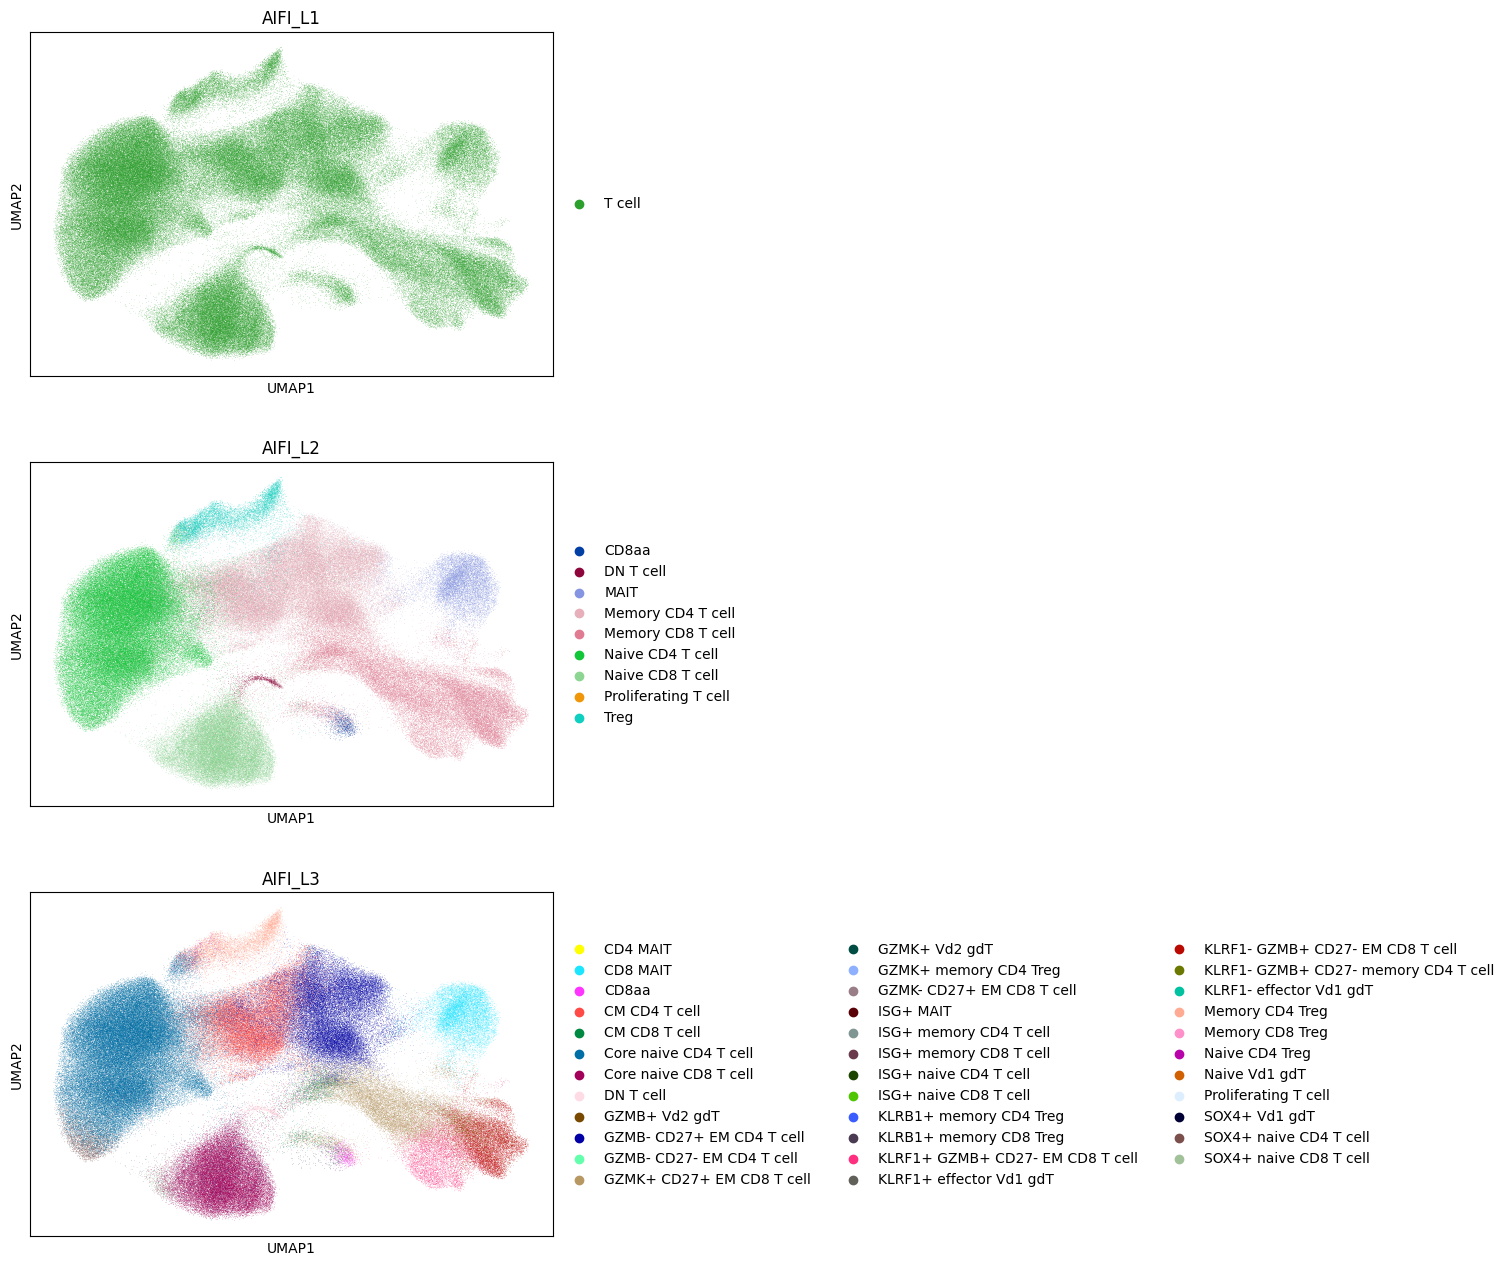

In [15]:
sc.pl.umap(combined_T_subset, color=["AIFI_L1","AIFI_L2","AIFI_L3"],ncols=1)

In [16]:
filtered_columns = combined_T_subset.obs.filter(regex='GATA3|STAT6|TBX21|RBPJ|TCF7_|MAF_|BCL6').columns.tolist()
filtered_columns

['MAF_144-Motif',
 'BCL6_187-Motif',
 'BCL6B_218-Motif',
 'RBPJ_291-Motif',
 'GATA3_384-Motif',
 'TCF7_750-Motif',
 'STAT6_776-Motif',
 'TBX21_780-Motif']

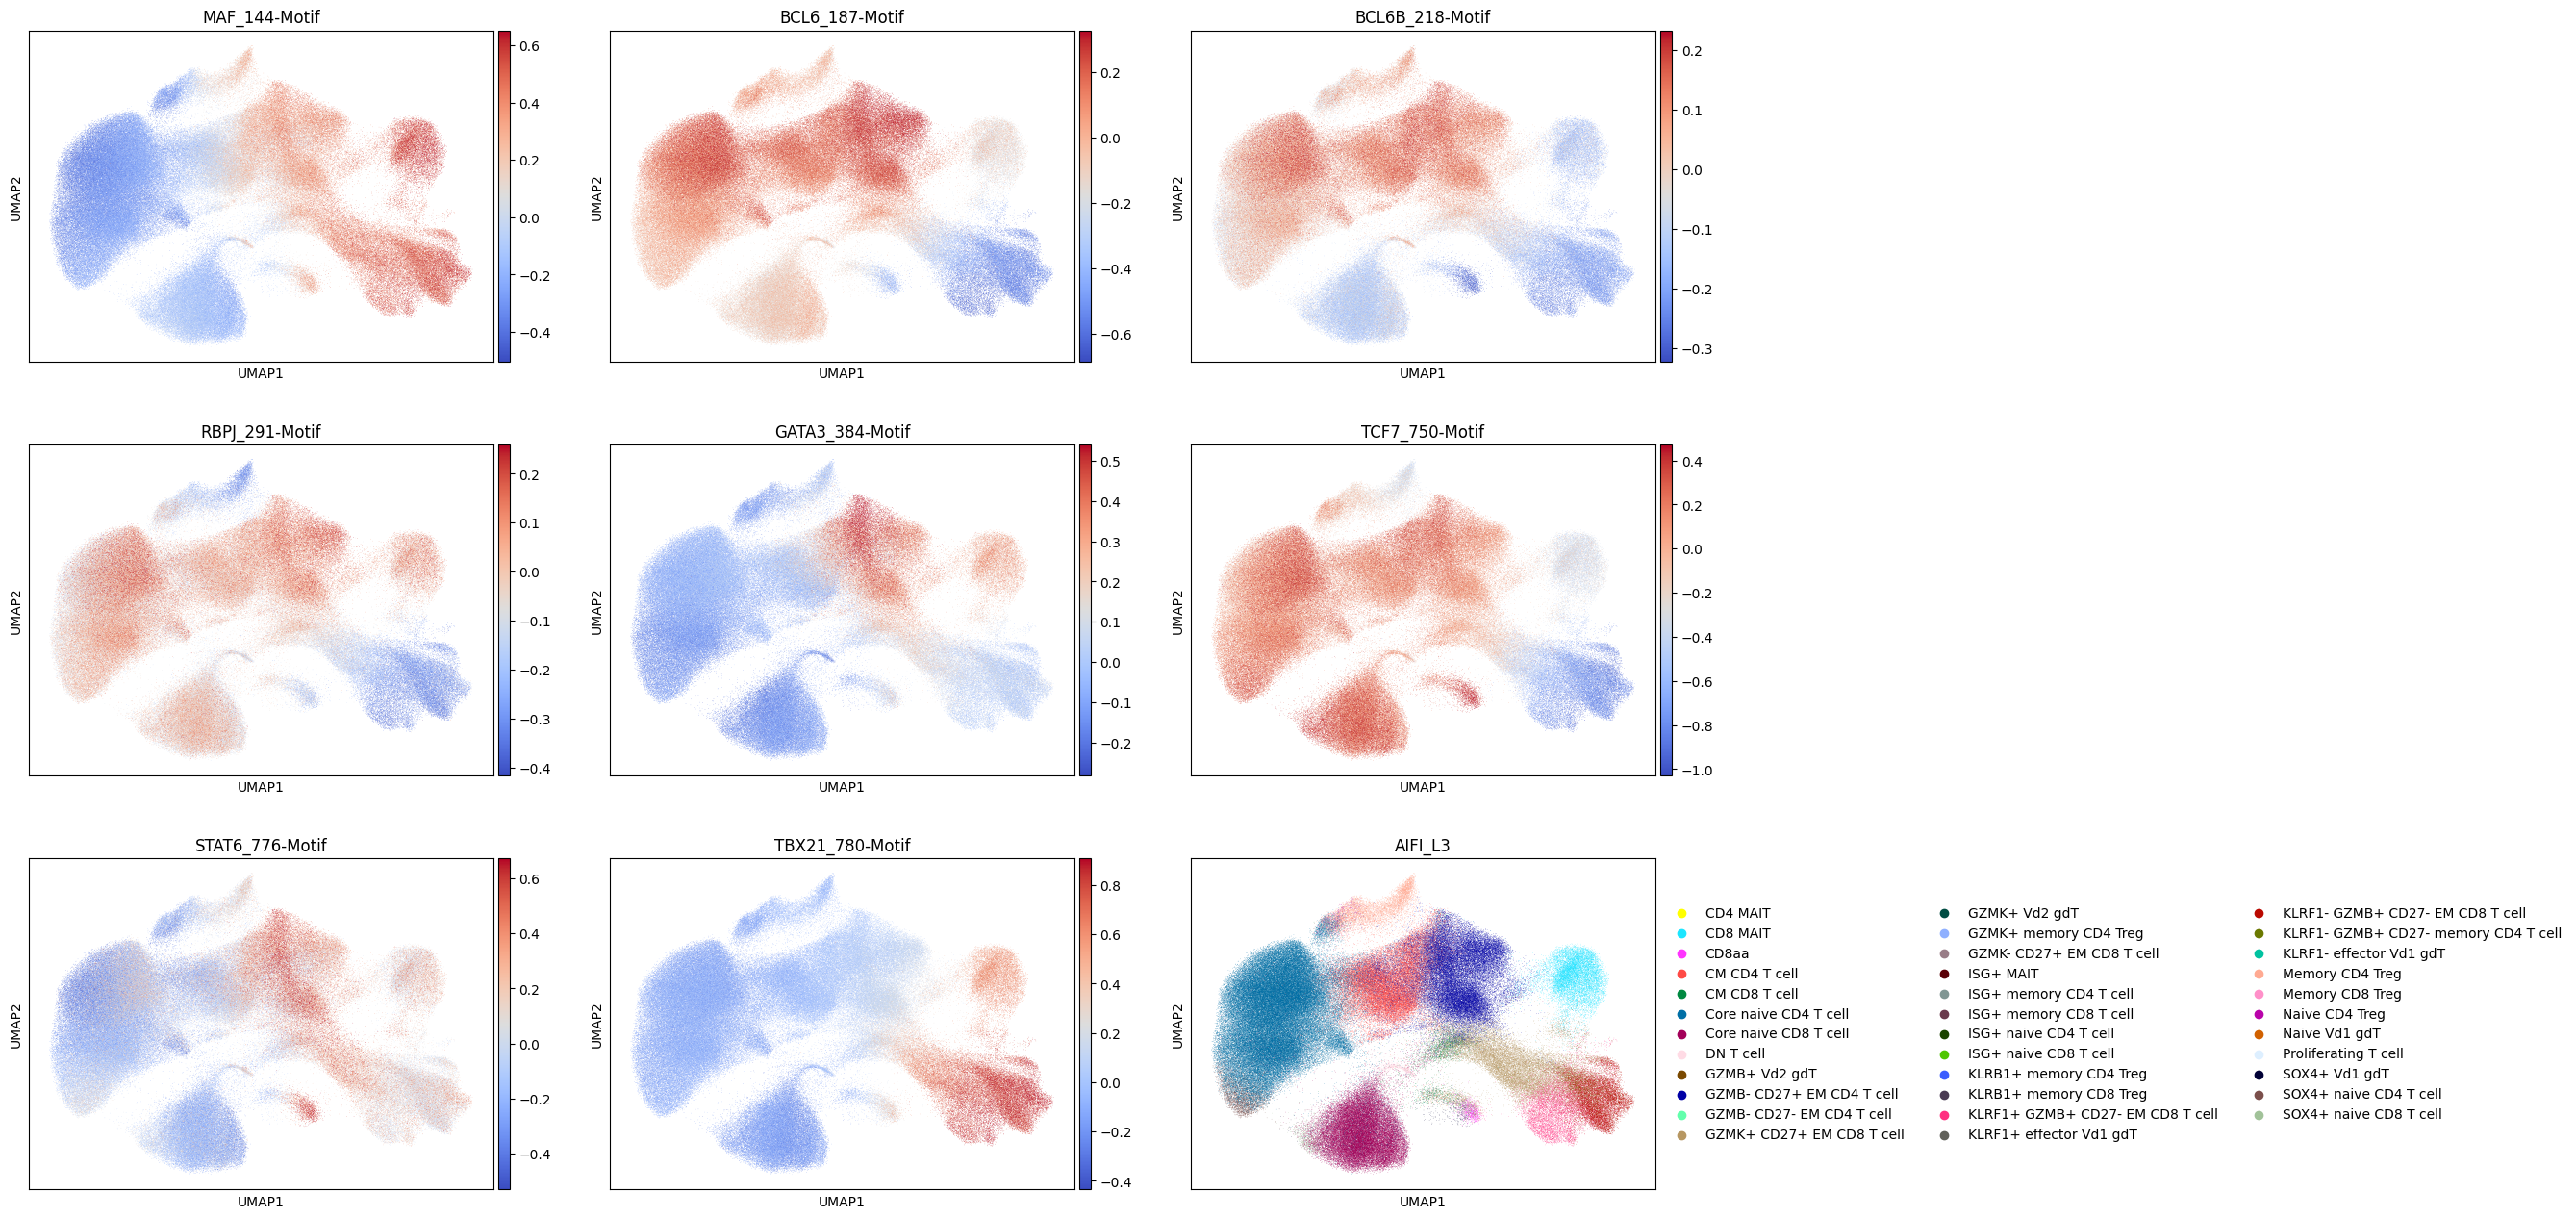

In [17]:
sc.pl.umap(combined_T_subset,size=0.5, color=filtered_columns+["AIFI_L3"],
           cmap='coolwarm',vmax='p99',vmin='p1',
           ncols=3)


# Violin Plots

In [18]:
selected_celltype=['GZMK+ CD27+ EM CD8 T cell',
                'KLRF1+ GZMB+ CD27- EM CD8 T cell',
                'KLRF1- GZMB+ CD27- EM CD8 T cell',
                'Core naive CD8 T cell']
selected_celltype=['CM CD4 T cell',
                'Core naive CD4 T cell',
                'GZMB- CD27- EM CD4 T cell',
                'GZMB- CD27+ EM CD4 T cell',
                'KLRF1- GZMB+ CD27- memory CD4 T cell']
combined_T_subset_filtered=combined_T_subset[combined_T_subset.obs['AIFI_L3'].isin (selected_celltype)].copy()

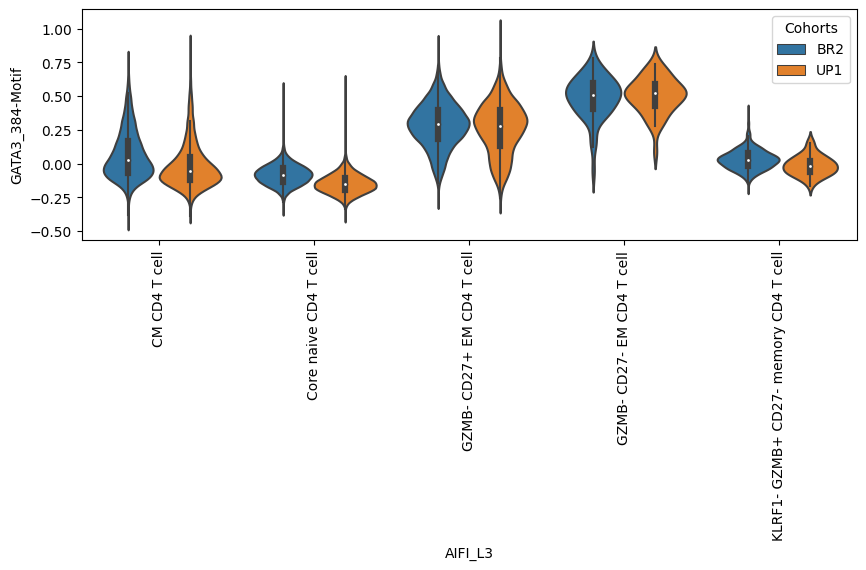

In [19]:
plt.rcParams['figure.figsize'] = [10, 3]
ax=sns.violinplot(data=combined_T_subset_filtered.obs, x="AIFI_L3", y="GATA3_384-Motif",hue="Cohorts")
ax.tick_params(axis='x', rotation=90)

# Mean Expression Boxplots

In [20]:
grouped_means_motif = combined_T_subset_filtered.obs.groupby(['AIFI_L3', 'subject_id'])[filtered_columns].mean().reset_index()
grouped_means_motif['Cohorts']=[element[0:3] for element in grouped_means_motif['subject_id']]

IndexError: index 7 is out of bounds for axis 0 with size 7

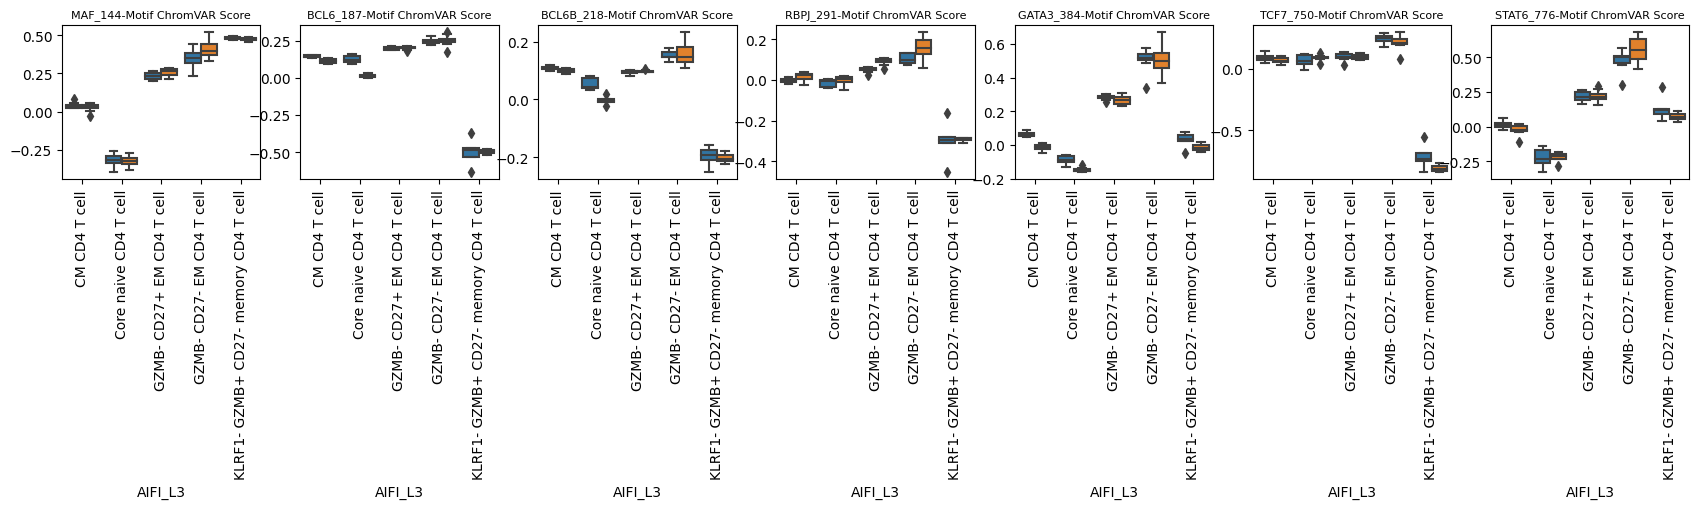

In [22]:
num_columns = 7
num_rows = (len(filtered_columns) + 1) // num_columns
fig, axs = plt.subplots(num_rows, num_columns, figsize=(3*num_columns, 2*num_rows))
axs = axs.flatten()  

for i, group in enumerate(filtered_columns):
    ax = sns.boxplot(x='AIFI_L3', y=group, hue='Cohorts', data=grouped_means_motif, ax=axs[i])
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('')

    ax.set_title(f'{group} ChromVAR Score',size=8)
    ax.get_legend().remove()
plt.tight_layout()

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1), borderaxespad=0.)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.show()


# GZMK with Motif Scores

In [261]:
gene='LGALS1'
selected_celltype=['GZMK+ CD27+ EM CD8 T cell',
                'KLRF1+ GZMB+ CD27- EM CD8 T cell',
                'KLRF1- GZMB+ CD27- EM CD8 T cell',
                'Core naive CD8 T cell']
selected_celltype=['CM CD4 T cell',
                'Core naive CD4 T cell',
                'GZMB- CD27- EM CD4 T cell',
                'GZMB- CD27+ EM CD4 T cell',
                'KLRF1- GZMB+ CD27- memory CD4 T cell']
combined_T_subset_filtered=combined_T_subset[combined_T_subset.obs['AIFI_L3'].isin (selected_celltype)].copy()

In [262]:
grouped_means_motif = combined_T_subset_filtered.obs.groupby(['AIFI_L3', 'subject_id'])[filtered_columns].mean().reset_index()
grouped_means_motif['Cohorts']=[element[0:3] for element in grouped_means_motif['subject_id']]

In [263]:
combined_T_subset_filtered=combined_T_subset_filtered.raw.to_adata()


In [264]:
sc.pp.normalize_total(combined_T_subset_filtered, target_sum=1e4)
sc.pp.log1p(combined_T_subset_filtered)

In [265]:
df_RNA_Mean_Expression=grouped_obs_mean(combined_T_subset_filtered,['AIFI_L3', 'subject_id'])

In [266]:
df_RNA_Mean_Expression_selected=pd.DataFrame(df_RNA_Mean_Expression.loc[gene])

In [267]:
df_RNA_Mean_Expression_selected[['AIFI_L3', 'subject_id']] = df_RNA_Mean_Expression_selected.index.to_series().str.split(':', expand=True)

In [268]:
df_RNA_Mean_Expression_selected['Cohorts']=[element[0:3] for element in df_RNA_Mean_Expression_selected['subject_id']]

In [269]:
df_RNA_Mean_Expression_selected=df_RNA_Mean_Expression_selected.reset_index()

In [270]:
df_RNA_Mean_Expression_selected=df_RNA_Mean_Expression_selected.merge(grouped_means_motif, how='left')

Text(0, 0.5, '')

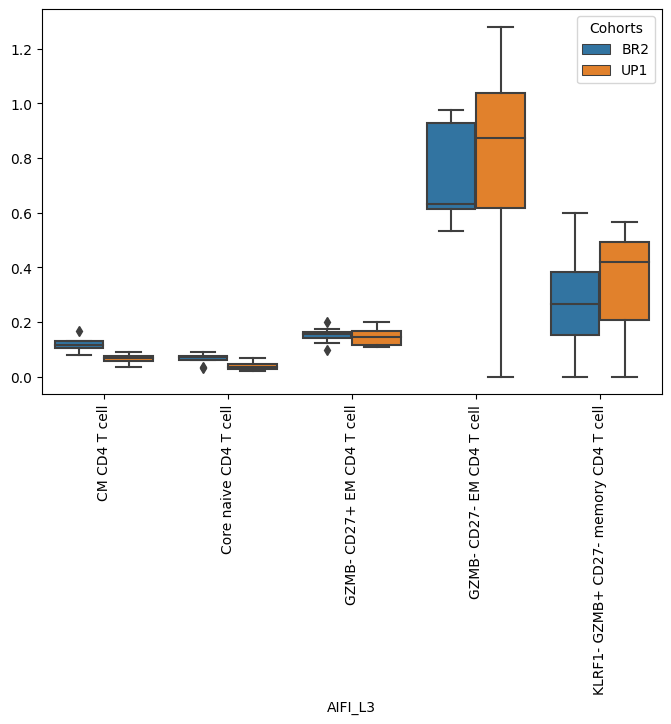

In [271]:
    ax = sns.boxplot(x='AIFI_L3', y=gene, hue='Cohorts', data=df_RNA_Mean_Expression_selected)
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('')

### GATA3

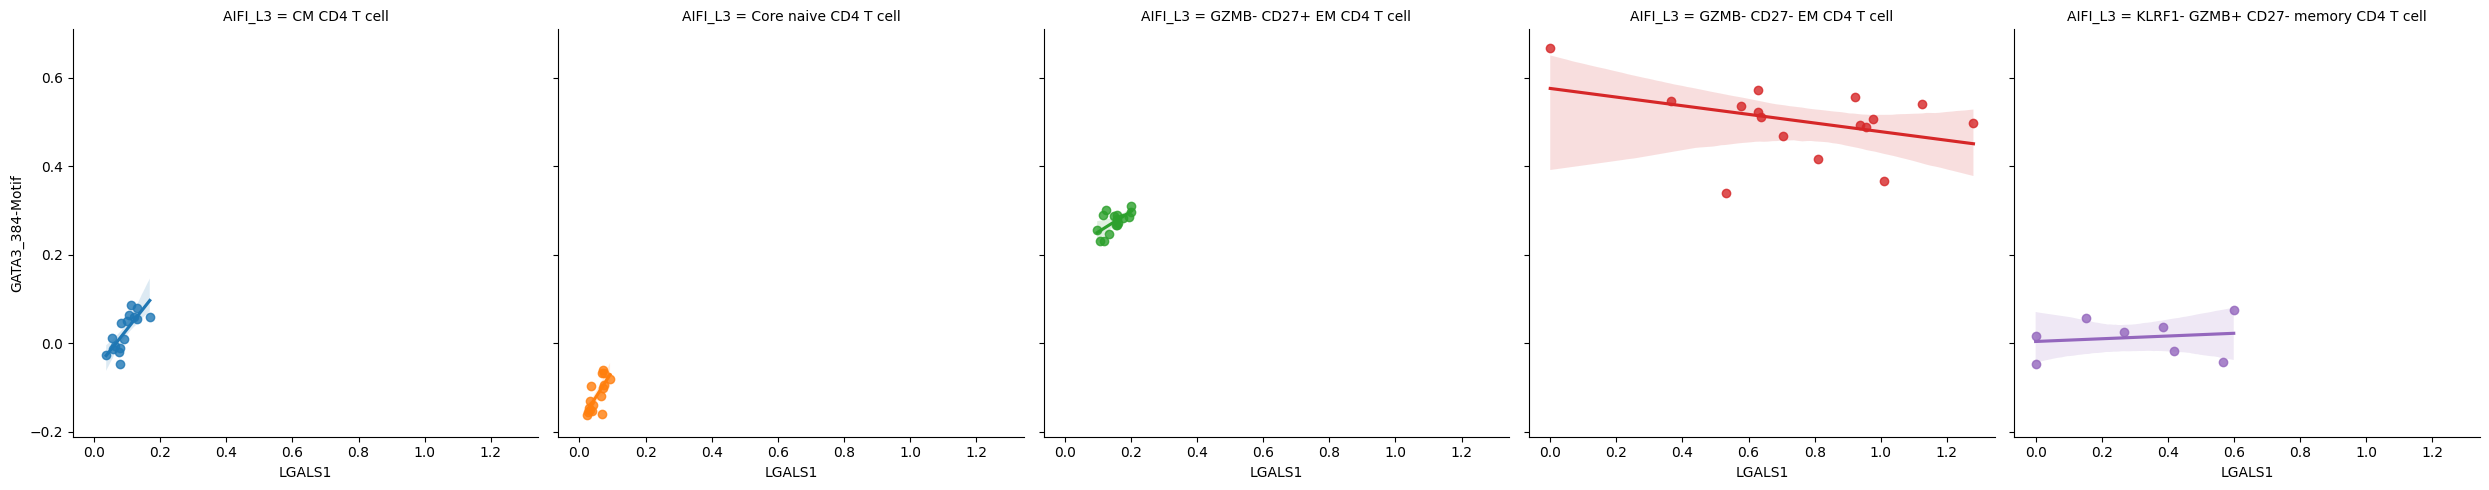

In [272]:
plt.rcParams['figure.figsize'] = [8, 5]

sns.lmplot(data=df_RNA_Mean_Expression_selected, x=gene, y="GATA3_384-Motif", hue="AIFI_L3",col='AIFI_L3')


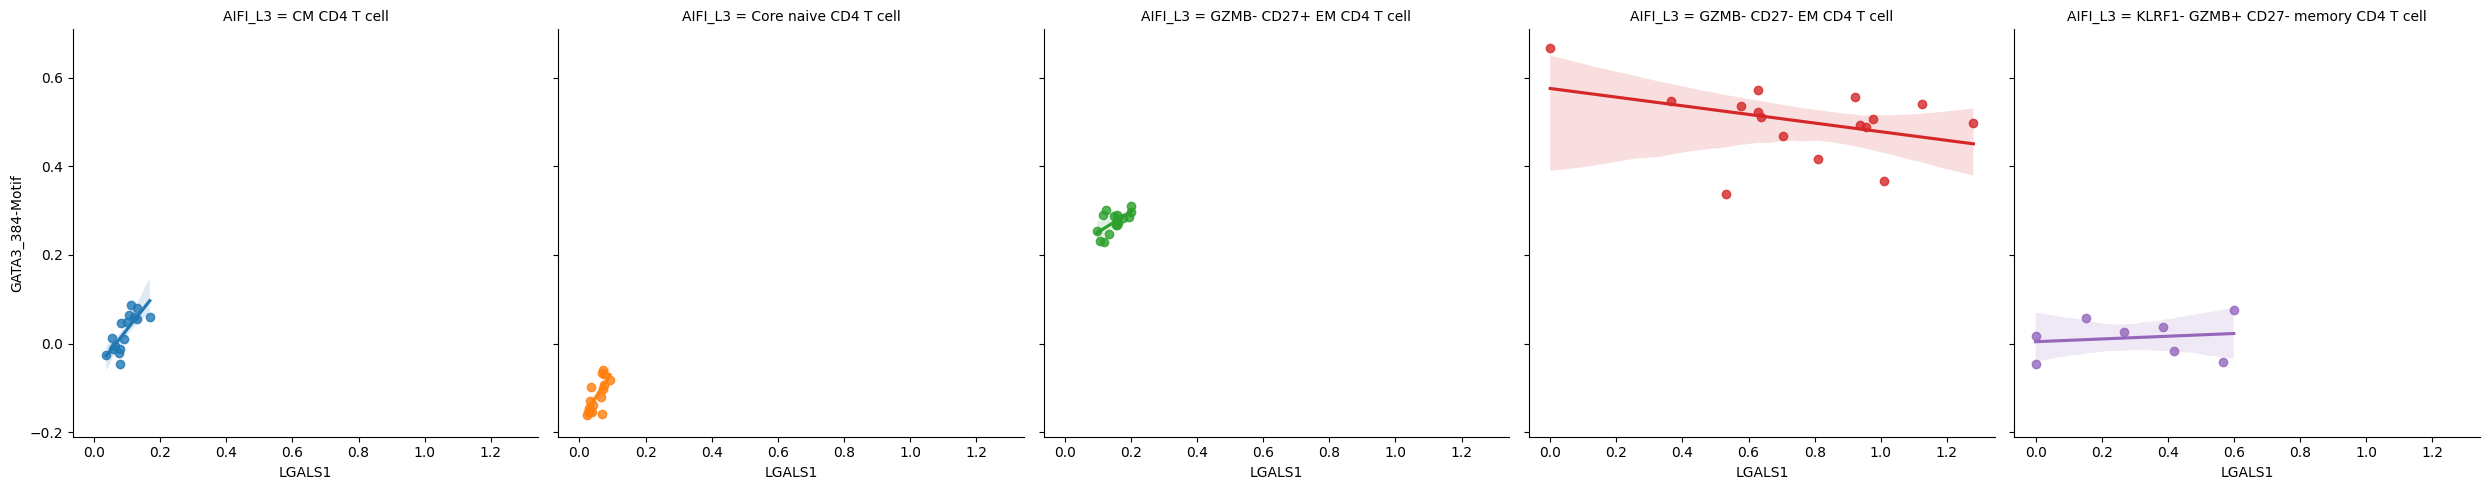

In [273]:
sns.lmplot(data=df_RNA_Mean_Expression_selected, x=gene, y="GATA3_384-Motif", hue="AIFI_L3", height=5,col='AIFI_L3')

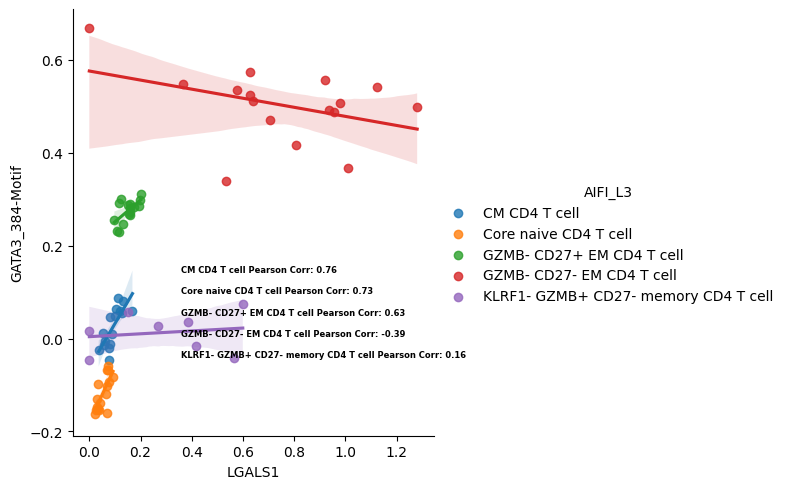

In [274]:

g = sns.lmplot(data=df_RNA_Mean_Expression_selected, x=gene, y="GATA3_384-Motif", hue="AIFI_L3", height=5)

grouped = df_RNA_Mean_Expression_selected.groupby('AIFI_L3')
y_text_position = 0.4 
for name, group in grouped:
    corr = group[gene].corr(group['GATA3_384-Motif'])
    ax = plt.gca()
    ax.text(.3, y_text_position, f'{name} Pearson Corr: {corr:.2f}', size=6,transform=ax.transAxes, verticalalignment='top', fontweight='bold')
    y_text_position -= 0.05 

plt.show()

### STAT6 

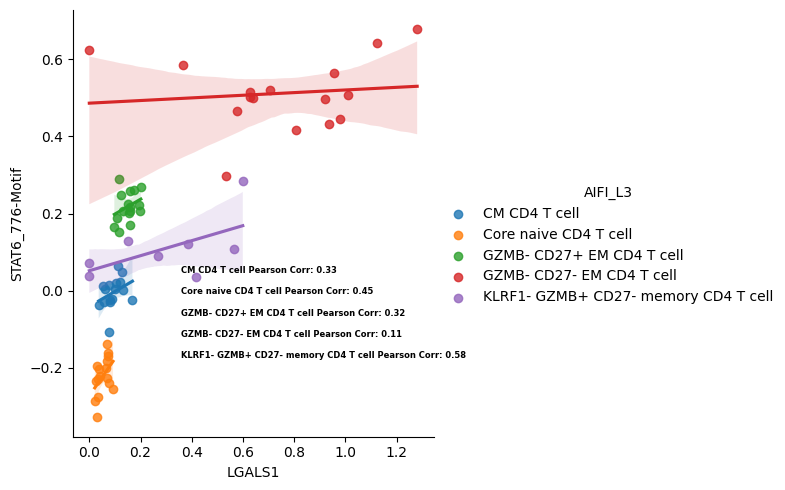

In [275]:

g = sns.lmplot(data=df_RNA_Mean_Expression_selected, x=gene, y="STAT6_776-Motif", hue="AIFI_L3", height=5)

grouped = df_RNA_Mean_Expression_selected.groupby('AIFI_L3')
y_text_position = 0.4 
for name, group in grouped:
    corr = group[gene].corr(group['STAT6_776-Motif'])
    ax = plt.gca()
    ax.text(.3, y_text_position, f'{name} Pearson Corr: {corr:.2f}', size=6,transform=ax.transAxes, verticalalignment='top', fontweight='bold')
    y_text_position -= 0.05 

plt.show()